In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [8]:
filenames = os.listdir("/home/jesterrexx/Documents/Dataset/cd combine/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
df.head()

,filename,category
0,dog.911.jpg,1
1,dog.815.jpg,1
2,cat.3115.jpg,0
3,dog.1470.jpg,1
4,cat.1547.jpg,0


In [10]:
df.tail()

,filename,category
8000,cat.277.jpg,0
8001,dog.573.jpg,1
8002,dog.2502.jpg,1
8003,cat.3922.jpg,0
8004,dog.810.jpg,1


<AxesSubplot:>

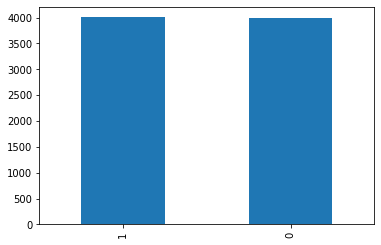

In [11]:
df['category'].value_counts().plot.bar()

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [17]:
earlystop = EarlyStopping(patience=10)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
callbacks = [earlystop, learning_rate_reduction]

In [20]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [21]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

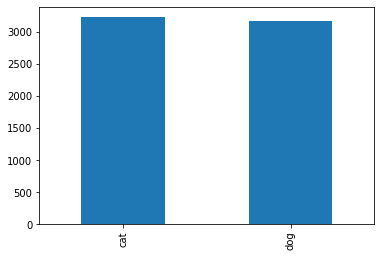

In [22]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

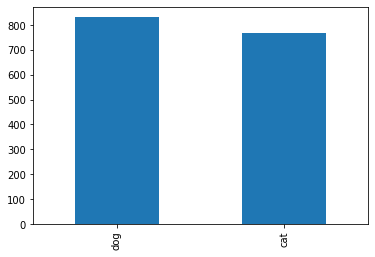

In [23]:
validate_df['category'].value_counts().plot.bar()

In [24]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/home/jesterrexx/Documents/Dataset/cd combine/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6404 validated image filenames belonging to 2 classes.


In [35]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "//home/jesterrexx/Documents/Dataset/cd combine/test", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


/home/jesterrexx/.local/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1601 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [27]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/home/jesterrexx/Documents/Dataset/cd combine/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


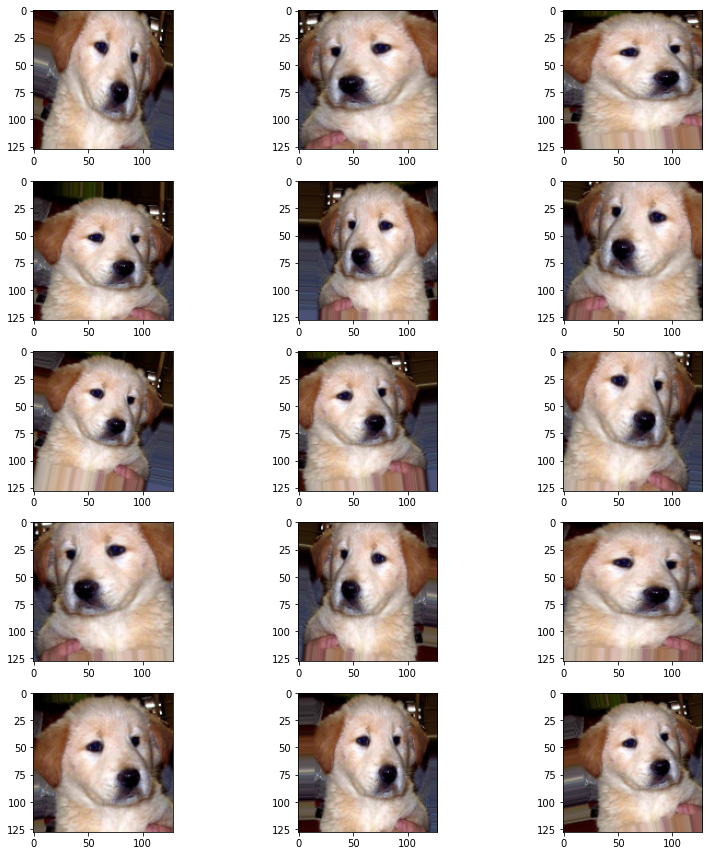

In [28]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [36]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
426/426 [==============================] - 244s 573ms/step - loss: 0.9477 - accuracy: 0.5846
Epoch 2/50
426/426 [==============================] - 269s 631ms/step - loss: 0.6517 - accuracy: 0.6533
Epoch 3/50
426/426 [==============================] - 232s 546ms/step - loss: 0.5951 - accuracy: 0.6923
Epoch 4/50
426/426 [==============================] - 232s 544ms/step - loss: 0.5543 - accuracy: 0.7258
Epoch 5/50
426/426 [==============================] - 231s 543ms/step - loss: 0.5272 - accuracy: 0.7435
Epoch 6/50
426/426 [==============================] - 231s 543ms/step - loss: 0.5157 - accuracy: 0.7497
Epoch 7/50
426/426 [==============================] - 232s 546ms/step - loss: 0.5032 - accuracy: 0.7662
Epoch 8/50
426/426 [==============================] - 234s 549ms/step - loss: 0.4797 - accuracy: 0.7773
Epoch 9/50
426/426 [==============================] - 236s 553ms/step - loss: 0.4838 - accur

# Save Model


In [37]:
model.save_weights("model.h5")